<a href="https://colab.research.google.com/github/nikolina-p/NLP-with-Transformers/blob/main/Multilingual_NER_head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MULTILINGUAL NER**
Fine-tuning of XLM-RoBERTa model - a model that is trained on multilingual corpus of data for masked language modeling - to do NER.

Goals:
1. Fine-tune it to do a named entity recognition (NER).

2. Also, we want to showcase a zero-shot cross-lingual transfer - we will fine-tune the model on one language (German) and then use it for NER on other languages (Italian, French, English).

Tasks we have to do:
1. Find a **labeled** datasets that we can use to train the base model for NER and prepare it for training.
2. Code the head that we will add to the base model body. Fun_fact: there is no XLMRobertaModel class - instead XLM-R model is RobertaModel class + XLMRobertaConfig.
3. Load untrained model + our token classification head
4. Prepare validation metrics
5. Train the model
6. Performance and error analysis - we will calculate F1 score to measure performance, and we will examine tokens and sequences with the highest and lowes loss values and try to make conclusions what might drive the performace down.
7. Zero-shot cross-lingual transfer - we will do multiple tests:
    - validate a model trained on German corpus on validation data in French, Italian, English and calculate F1 scores
    - validate a model trained on mix of German and French corpus of and test on other languages
    - train a model on all languages and test on each of the languages

In [1]:
!pip install huggingface_hub

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
!huggingface-cli whoami

nikolina-p


In [4]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.1 MB/s eta 0:00:00


## **1. Loading the dataset**

Steps:
1. Load the "Swiss dataset" from the Huggingface hub
2. Create representable mix of Swiss languages - save it in `panx_ch`
3. Extract existing class labels from the dataset - save it in `tags`
4. Check if the dataset is balanced in terms of number of tagged tokens per class

In [5]:
from datasets import get_dataset_config_names
from datasets import load_dataset

xtreme_subsets = get_dataset_config_names("xtreme")  # "configurations" are different subsets of a dataset
print(f"XTREME has {len(xtreme_subsets)} configurations\n\n")

panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
print(f"{panx_subsets[:3]} \n\n")

panx_de_sample = load_dataset("xtreme", name="PAN-X.de")  # loads only German for inspection
panx_de_sample

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

XTREME has 183 configurations


['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg'] 




train-00000-of-00001.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/590k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

**Extract the Swiss languages corpus**

Here, we are preparing a dataset that will represent Swiss languages, each one represented in proportion to number of speakers. The text is already labeled with classes like LOC, PER, ORG. `panx_ch`

We are creating `tags` variable which will be used to prepare XML-R configuration.

Also, `panx_ch` dataset is created fot training and validation.

### `panx_ch`

In [5]:
from collections import defaultdict
from datasets import DatasetDict
from datasets import load_dataset

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]  # percentage of speakers

# Returns a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)
for lang, frac in zip(langs, fracs):
    # Load monolingual corpus for each langs
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0)  # As long as the seed value is the same, calling shuffle() will produce the same shuffled result every time.
            .select(range(int(frac * ds[split].num_rows)))
            )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/590k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/837k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/932k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/459k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/464k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Here, we are looking at what labels exist in training dataset, and those are ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'].

We will put them in variable `tags` that we will use later for setting up the model's configuration.

### `tags`

In [6]:
# look at the metadata (features) of dataset to check what labels are used. They are kept in an ClassLabel object
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}\n\n")

tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)


langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


### `de_example`

In [21]:
# inspecting the German "train" dataset
de_example = panx_ch["de"]["train"]  # datasets.arrow_dataset.Dataset

for i in de_example.features.items():  # dataset metadata
     print(f"{i} \n")
print(type(de_example['langs']))  # actual data in lists
print(len(de_example["langs"]))
print(de_example["tokens"][1])


('tokens', Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)) 

('ner_tags', Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)) 

('langs', Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)) 

<class 'list'>
12580
['Sie', 'geht', 'hinter', 'Walluf', 'nahtlos', 'in', 'die', 'Bundesautobahn', '66', 'über', '.']


### some more testing and inspecting

In [ ]:
# a function from the book that is adding "ner_tag_str" (string names for each label) to datasets
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}  # int2str is a ClassLabel function

# example of usage on German language corpus
panx_de = panx_ch["de"].map(create_tag_names)
panx_de

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [ ]:
for key, val in panx_de['train'].features.items():
    print(panx_de['train'][key][3])

["'", "''", 'Stade', 'Reims', "''", "'"]
[0, 0, 3, 4, 0, 0]
['de', 'de', 'de', 'de', 'de', 'de']
['O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']


TEST the dataset: check if number of labels is balanced

In [ ]:
from collections import Counter
import pandas as pd

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [ ]:
# EXAMPLE OF datasets classes
from datasets import Dataset, Features, Value, Sequence

x_features = Features({
    "tokens": Sequence(feature=Value(dtype="string")),
})

x_data = Dataset.from_dict({
    "tokens": [["Hello", "world"], ["Hugging", "Face", "rocks"]],
}, features=x_features)

print(x_data.features)
print(f"{type(x_data)}\n\n")
print(f"{x_data}\n\n")
print(f"{x_data['tokens']}\n\n")

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}
<class 'datasets.arrow_dataset.Dataset'>


Dataset({
    features: ['tokens'],
    num_rows: 2
})


[['Hello', 'world'], ['Hugging', 'Face', 'rocks']]




## **2. Token Classification Head**

`cls XLMRobertaForTokenClassification`

Transformers does not have a separate XLMRobertaModel class because XLM-R and RoBERTa share the same architecture. Instead, they both use RobertaModel, but with different configurations.
**When RobertaModel is initialized with XLMRobertaConfig, it behaves as an XLM-R model.**

`RobertaPreTrainedModel` is a base class for all models that are based on RoBERTa (it is not the model itself, tho). It adds functionality like
- loading model weights from pretrained model,
- initializing the model weights (random) when adding a new layer or training a model from scratch,
- saving model,
- includes some built-in configuration like size of the model, number of labels, dropput probabilities.

_Here, we will code the token classification head_

In [7]:
import torch.nn as nn
from transformers import XLMRobertaConfig  # XLM-R part of the model
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel  # actuall RoBERTa model
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    # This tells Hugging Face’s model loading functions which configuration class to use when instantiating a model (.from_pretrained() for example).
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)

        self.num_labels = config.num_labels

        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)

        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Load and initialize weights
        self.init_weights()


    def forward(self, input_ids=None, attention_mask=None,
                token_type_ids=None, labels=None, num_items_in_batch=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)

        # Apply classifier to encoder representation - HEAD
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)  # matrix no_tokens X no_labels - calculates prob. of each label for each token

        # Calculate losses
        loss = None
        if labels is not None:
            # labels are not None in training session, because training data sets are labeled
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## **3. Loading our model**
a. Prepare the tokenizer and config
- loading tokenizer
- loading the configuration (adding the tags: tag-names mapping to our configuration)

b. Load the model

### **a. Prepare the tokenizer and config**

`xlmr_tokenizer`    `xlmr_config`

#### **load tokenizer** `xlmr_tokenizer`

In [8]:
# initialize appropriate TOKENIZER for XLM-R
from transformers import AutoTokenizer

xlmr_model_name = "xlm-roberta-base"

xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
xlmr_tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)

In [15]:
import pandas as pd

`input_ids`

In [10]:
# testing the loaded XLM-RoBERTa model tokenizer (XLMRobertaTokenizer)

text = "Jack Sparrow loves New York!"

xlmr_tokens = xlmr_tokenizer(text).tokens()
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


#### inspecting the tokenized text

Trying to see where do the word_ids come from

In [ ]:
# inspecting the tokenizer little bit more
my_text = "Nikolinamina uci AI"
tokenizovan_text = xlmr_tokenizer(my_text)  # my_text.split(), is_split_into_words=True
print(tokenizovan_text.keys())
print(tokenizovan_text['input_ids'])
pd.DataFrame([tokenizovan_text.tokens(), tokenizovan_text['input_ids'], tokenizovan_text.word_ids()], index=["Tokens", "Input IDs", "Word IDs"])


dict_keys(['input_ids', 'attention_mask'])
[0, 86273, 885, 10593, 75, 318, 38730, 2]


,0,1,2,3,4,5,6,7
Tokens,<s>,▁Nikol,ina,mina,▁u,ci,▁AI,</s>
Input IDs,0,86273,885,10593,75,318,38730,2
Word IDs,None,0,0,0,1,1,2,None


In [ ]:
vars(tokenizovan_text)

{'data': {'input_ids': [0, 86273, 885, 10593, 75, 318, 38730, 2],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]},
 '_encodings': [Encoding(num_tokens=8, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])],
 '_n_sequences': 1}

In [ ]:
# inspecting _encodings objects
tte = tokenizovan_text.encodings
tte[0]

Encoding(num_tokens=8, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
# it seems to me it uses "offsets" to keep track of which token belongs to what word
for a in ['ids', 'type_ids', 'tokens', 'offsets', 'attention_mask', 'special_tokens_mask', 'overflowing']:
    print(getattr(tte[0], a))

[0, 86273, 885, 10593, 75, 318, 38730, 2]
[0, 0, 0, 0, 0, 0, 0, 0]
['<s>', '▁Nikol', 'ina', 'mina', '▁u', 'ci', '▁AI', '</s>']
[(0, 0), (0, 5), (5, 8), (8, 12), (13, 14), (14, 16), (17, 19), (0, 0)]
[1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 1]
[]


In [ ]:
type(tte)

list

#### **prepare configuration** `xlmr_config`

In [9]:
# create mappings label_IDs and label_names to be added to model configuration in the next step
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

print(f"{index2tag}\n\n")
print(f"{tag2index}\n\n")

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}




In [10]:
# LOAD THE RoBERTa configuration, but CHANGE number of labels, and provide mappings label_IDs and label_names
from transformers import AutoConfig

# default configuration before the CHANGE
default_xlmr_config = AutoConfig.from_pretrained(xlmr_model_name)
default_xlmr_config


XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [11]:
# the configuration after the CHANGE
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag,
                                         label2id=tag2index)
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

### **b. Loading our untrained model**

`xlmr_model`

In [12]:
# load the model's WEIGHTS - this is the model with our custom HEAD
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# test our model on sample text ("Jack Sparrow loves New York!") input_ids
outputs = xlmr_model(input_ids.to(device)).logits
outputs

tensor([[[ 0.3695, -0.1612, -0.2960,  0.3531,  0.7444, -0.9453,  0.0504],
         [ 0.2368,  0.0163,  0.1857,  0.4413,  0.7890, -0.8658, -0.1634],
         [ 0.0424,  0.0372,  0.2289,  0.5353,  0.9073, -0.8796, -0.1841],
         [ 0.2610,  0.0639,  0.2880,  0.5466,  0.7928, -0.7643, -0.1042],
         [ 0.3348,  0.0371,  0.2622,  0.5101,  0.7204, -0.7837, -0.1520],
         [ 0.1769,  0.0035,  0.2010,  0.4817,  0.8126, -0.8150, -0.1334],
         [ 0.2487,  0.0334,  0.1180,  0.5111,  0.7718, -0.8163, -0.1141],
         [ 0.3321, -0.0121,  0.1775,  0.5267,  0.7315, -0.8538, -0.1335],
         [ 0.2050, -0.0185,  0.2229,  0.5162,  0.7525, -0.8708, -0.2188],
         [ 0.4038, -0.1245, -0.2811,  0.3364,  0.7213, -1.0276,  0.0967]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
# closer look at logits, matrix that holds label probabilities for each token
predictions = torch.argmax(outputs, dim=-1)
predictions

tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]], device='cuda:0')

In [ ]:
# make predictions - for each token choose the higest probability label
# predictions do not make much sense because the model is not trained yet
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG


In [13]:
# previous lines of code in one function
def tag_text(text, tags, model, tokenizer, device):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()

    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

    # Get predictions as distribution over 7 possible classes
    # outputs: [1, 10, 7]  # (batch_size=1, num_tokens=10, num_classes=7)
    #   dim=0 → Batch dimension (since transformers process multiple sequences at once).
    #   dim=1 → Number of tokens in the sequence (10 tokens).
    #   dim=2 → Logits for each token (7 possible classes for each token).
    outputs = model(input_ids.to(device)).logits
    print(outputs)

    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    print(predictions)

    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [16]:
tag_text("Jack Sparrow loves New York!", tags, xlmr_model, xlmr_tokenizer, device)

tensor([[[ 0.3535,  0.2578, -0.3332, -0.2265, -0.2963, -0.1201,  0.0611],
         [ 0.1225,  0.1093, -0.1699,  0.0492, -0.4427,  0.1023, -0.0642],
         [ 0.2250,  0.1710, -0.3427,  0.0047, -0.4304,  0.0824, -0.0853],
         [ 0.0238,  0.0628, -0.2556,  0.0578, -0.4148,  0.1062, -0.0886],
         [ 0.1381,  0.1595, -0.1788,  0.0072, -0.3767,  0.0690, -0.0832],
         [ 0.0565,  0.2916, -0.3097,  0.0354, -0.3976,  0.1211, -0.0476],
         [ 0.1924,  0.1920, -0.2595, -0.0020, -0.4129,  0.0348, -0.1097],
         [ 0.0981,  0.1523, -0.2329,  0.0613, -0.3874,  0.0127, -0.0478],
         [ 0.1418,  0.2238, -0.2555,  0.0721, -0.4318, -0.0032, -0.0097],
         [ 0.3374,  0.2389, -0.3409, -0.2485, -0.2579, -0.1707,  0.1151]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[0, 0, 0, 5, 1, 1, 0, 1, 1, 0]], device='cuda:0')


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,O,O,O,B-LOC,B-PER,B-PER,O,B-PER,B-PER,O


# **4. Tokenizing the train dataset**

One of the tasks is **to mask all subwords and special tokens**, so that model do not make NER conclusions on these tokens. Masking the subwords is done to ensure that the model only makes predictions at the word level, not the subword level.
They are usin label ID -100 and label name IGN for this mask.
-100 is used as a label ID because PyTorch CrossEntropyLoss class has a parameter ignore_index = -100, and it ignores all the tokens with label_id = -100 when calculating the loss in backpropagation.

PyTorch provides **TWO ways** to compute cross-entropy loss **for classification problems**:

1. Using **torch.nn.CrossEntropyLoss** (as a class)
- This is an object-oriented approach where we create a loss function instance (loss_fn = nn.CrossEntropyLoss()).

2. Using **torch.nn.functional.cross_entropy** (as a function)
- This is a functional API where we directly call cross_entropy(logits, labels) without creating a class instance. We must explicitly set ignore_index=-100 in the function call. Unlike torch.nn.CrossEntropyLoss, the functional API does not have ignore_index=-100 as a default.


In [22]:
# (test!) prepare and test the tokenization step (using de_example as a test)
import pandas as pd

words, labels = de_example["tokens"], de_example["ner_tags"]

tokenized_input = xlmr_tokenizer(words, is_split_into_words=True)
[k for k in tokenized_input.keys()]

['input_ids', 'attention_mask']

In [ ]:
type(tokenized_input)

transformers.tokenization_utils_base.BatchEncoding

In [81]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"][1])

# each sequence has its own IDs for words; all the parts of one word have the same ID
word_ids = tokenized_input.word_ids()

pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁Sie,▁geht,▁hinter,▁Wall,uf,▁na,ht,los,▁in,...,▁über,▁,.,</s>,NaN,NaN,NaN,NaN,NaN,None
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10.0,10.0,10.0,11.0,11.0,None


**Mask all the subwords **

We want to mask all the sufixes and special tokens. We will mask all the tokens that are part of the same word leaving only the first token for each word.

In [82]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[0][word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁Sie,▁geht,▁hinter,▁Wall,uf,▁na,ht,los,▁in,...,▁über,▁,.,</s>,None,None,None,None,None,None
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


**The full function for tokenization of our whole training data subset.**

In [17]:
# FROM THE BOOK
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

`encode_panx_dataset`

In [18]:
# tokenization mapping function Datasets.map() - this is NOT standard Python map()
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

`panx_de_encoded` - tokenized train dataset, German

In [19]:
# FINAL RESULT: tokenized dataset German corpus
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

# **5. Performance measure**


In [20]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# **6. Fine-tunning FINALLY**

The plan is to now fine-tune the model on German, and then use other languages' validation sets to validate the results.

Important classes:

`Trainer`

`TrainingArguments`

`DataCollatorForTokenClassification`


In [21]:
# preparing training arguments
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24  # how many sentences is processed together
logging_steps = len(panx_de_encoded["train"]) // batch_size  # logging_steps = total num of batches, which means logging will be done after model is done with all the baches, which is after one epoch
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error", # other log levels: "warning", "debug", "info", "critical"
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size, # This sets the number of training samples processed per device (GPU/CPU) in one forward/backward pass in TRAINING
    per_device_eval_batch_size=batch_size,  # same thing but for VALIDATION. Sometimes, larger batch sizes can be used for evaluation because gradient updates aren't needed.
    eval_strategy="epoch",  # Other Possible Values "no" → No evaluation during training. "steps" → Evaluates every eval_steps (e.g., every 500 steps).
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    # push_to_hub=True
    )

# warning msg: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

In [22]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=068fd90cac0b1e57fd4d5a5d63a3bf761c23b87a8012fa12bbd29ed51540df53
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [23]:
# setting up a function for predictions evaluation that will be performed after each epoch
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [24]:
# setting up a data_collator that will pad each sequence to the size of the longest sequence in the bach.
# DataCollatorForTokenClassification is special for token classification because it pads also the label Sequences, besides token Sequences
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [25]:
# initialize the "fresh" model
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [26]:
# setting up the Trainer object
from transformers import Trainer

trainer = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  processing_class=xlmr_tokenizer)

# warning msg: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

In [27]:
from accelerate import Accelerator

accelerator = Accelerator()

In [28]:
# START TRAINING
trainer.train()
# trainer.push_to_hub(commit_message="Training completed!")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nikolinap85 (nikolinap85-na) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1
1,0.260200,0.154433,0.824681
2,0.127300,0.144786,0.840750
3,0.079400,0.135755,0.860257


TrainOutput(global_step=1575, training_loss=0.15553996897879102, metrics={'train_runtime': 155.3472, 'train_samples_per_second': 242.94, 'train_steps_per_second': 10.139, 'total_flos': 862324400720376.0, 'train_loss': 0.15553996897879102, 'epoch': 3.0})

In [29]:
# test the model in German
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer, device)  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor([[[ 4.1252,  0.6329, -0.2812, -0.2322, -0.9989,  0.3231, -1.9623],
         [-0.8047,  7.1456, -0.8342,  0.9177, -2.0361, -1.5821, -3.5648],
         [-1.1968, -0.1325,  7.7236, -2.3097,  0.8931, -3.0816, -1.1832],
         [-0.7691,  0.6605,  7.3912, -2.3704,  0.2770, -3.2454, -1.3424],
         [ 8.7963, -1.7404, -0.7497, -1.5063, -1.2758, -1.8044, -2.0856],
         [ 8.6908, -1.3567, -0.9383, -1.1605, -1.6101, -1.7169, -2.3341],
         [ 5.8418,  0.4674, -1.4749,  0.9953, -1.7477, -1.4593, -3.5756],
         [ 6.1842, -0.7121,  0.4743, -1.1362, -0.5796, -2.1261, -2.0598],
         [ 7.9731, -1.6105, -0.3764, -1.1770, -0.3920, -2.1066, -1.9704],
         [-0.6079,  1.2704, -2.3270,  6.5735, -0.5010,  0.2149, -4.3392],
         [ 8.0710, -2.3539, -0.3698, -2.1089,  0.0724, -1.8348, -1.1741],
         [-0.4320, -1.6063, -2.8026,  0.4254, -1.3544,  6.0891, -0.4240],
         [ 0.5761, -3.8567, -0.8484, -2.4467,  0.9733,  1.1240,  5.8360],
         [ 4.3773,  0.6553, -0.2499, -

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [31]:
# test the model in English - zero-shot cross-lingual transfer -- not great, not terrible!
text_de = "Jack Sparrow loves New York!"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer, device)  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor([[[ 0.2779,  0.0463,  0.3232, -0.5156,  0.1436, -0.3996, -0.3780],
         [-2.6119,  6.2537, -0.8523,  2.4569, -1.1744, -0.6699, -3.3859],
         [-2.7474, -0.7392,  6.9198, -2.0827,  2.7311, -2.8791, -0.2754],
         [-2.3450, -0.4116,  5.8341, -1.7654,  2.5476, -2.9094, -0.3997],
         [ 1.4997, -1.4646,  2.8067, -1.2980,  2.7624, -3.3884, -1.5860],
         [ 2.8512, -1.8937,  2.3585, -1.4872,  2.3042, -3.3394, -1.3858],
         [-2.1576, -1.2509, -0.8740,  1.0520,  0.8420,  3.3331, -0.2154],
         [-2.7128, -3.0843,  1.4647, -2.4399,  3.3077, -0.4723,  5.0809],
         [ 3.1575, -2.7610,  1.5209, -1.8498,  3.5127, -3.3853, -0.2737],
         [ 0.3573,  0.1144,  0.4219, -0.5032,  0.3232, -0.5301, -0.4315]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[2, 1, 2, 2, 2, 0, 5, 6, 4, 2]], device='cuda:0')


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,B-PER,I-PER,I-PER,I-PER,O,B-LOC,I-LOC,I-ORG,I-PER


# **7. Error analysis**

We want to sort the validation samples by model loss, and look at those with the **biggest loss**, but also at those with the **minimal loss** in which the model is the most confident.

Loss is calculated with `cross_entropy()` from `torch.nn.functional` package.



In [32]:
from torch.nn.functional import cross_entropy

# forward_pass_with_label() from the book
def forward_pass_validation(batch):
    # Pad inputs and labels - Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)

    # put all the tensor onto the device
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    # this is an inference(validation) phase so we are not updating model weights, no backpropagation, and so no gradients needed (torch.no_grad())
    with torch.no_grad():
        # check if the model is in evaluation mode
        if trainer.model.training:
            trainer.model.eval()
            print("Model swithced to eval mode.")
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

`batch = {

    "input_ids": [[1, 2, 3], [4, 5, 6]],
    "attention_mask": [[1, 1, 1], [1, 1, 0]],
    "labels": [[0, 1, 2], [1, 2, 0]]
    
}

features = [

    {"input_ids": [1, 2, 3], "attention_mask": [1, 1, 1], "labels": [0, 1, 2]},
    {"input_ids": [4, 5, 6], "attention_mask": [1, 1, 0], "labels": [1, 2, 0]}

]`

In [33]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_validation, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [34]:
valid_set.features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'loss': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
 'predicted_label': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [35]:
print(valid_set['input_ids'][0])
print(valid_set['labels'][0])
print(valid_set['predicted_label'][0])

[0, 10699, 11, 15, 16104, 1388, 2]
[-100, 3, -100, 4, 4, 4, -100]
[4, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
# return label and token IDs into names for easier understanding and pad the loss
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.0060996567, 0.0, 0.0074352683, 0.00845...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


**Examining the loss per token - tokens with the bigest loss.**

In [37]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.70,B-LOC,▁Luz
1,10,1,I-ORG,1.88,I-LOC,▁a


In [41]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁von,▁in,▁und,▁/,▁(,▁),▁'',▁A
count,6066,1388,808,989,1171,163,246,246,2898,125
mean,0.04,0.1,0.16,0.11,0.08,0.54,0.3,0.29,0.02,0.45
sum,221.02,137.61,129.15,110.44,91.96,87.45,74.63,72.2,71.05,56.48


In [42]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.64,0.6,0.49,0.34,0.25,0.17,0.03
sum,928.65,1606.75,1869.93,1083.77,730.13,690.44,1418.39


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

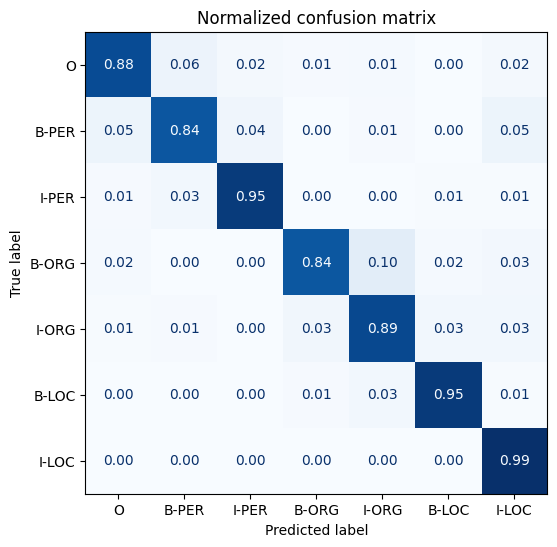

In [ ]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

**Now to examine sequences with big losses.**

In [ ]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.95,0.00,0.00,7.13,9.38,9.77,7.51,0.00,8.54,9.42,8.65,7.43,5.75,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,4.68,0.00,0.00,0.00,10.79,9.40,7.26,5.07,6.00,0.00,7.21,7.50,0.00,7.53,7.66,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.70,6.47,6.45,0.00,6.37,0.00,6.20,0.00,6.05,5.79,6.02,6.17,6.30,6.27,0.00


In [ ]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.03,0.00,0.00,0.02,0.02,0.00,0.01,0.00


Conclusion: there are errors in inference caused by the errors in original labels - this dataset was labeled automaticaly, which is a tehnique more prone to errors than labeling by humans. **In a real use case we would iterate on this step, cleaning up the dataset, retraining the model, and analyzing the new errors until we were satisfied with the performance.**

# **8. Cross-lingual transfer**

Using *encoded test splits* of each languag, test the German model and calculate F1 score.

In [44]:
# .predict() returns also predictions and (ground truth) labels if exist in dataset
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [49]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.868


In [50]:
# divided in 263 batches, 24 sequences per batch
len(panx_de_encoded["test"])

6290

In [51]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer, device)

tensor([[[ 3.4709,  0.3452, -0.3460, -0.5399, -0.8359,  0.4047, -1.6109],
         [-0.4078,  6.7477, -0.9000,  0.9608, -2.0927, -1.4634, -3.6108],
         [-1.1058, -0.2008,  7.5607, -2.2465,  0.9753, -3.1324, -1.2188],
         [-0.4936,  0.7097,  7.1698, -2.2702,  0.2464, -3.3992, -1.4587],
         [ 8.4271, -2.0669, -0.7940, -1.6038, -0.7435, -1.9163, -1.7934],
         [ 5.7787,  1.1666, -1.8823,  0.9090, -2.3173, -0.6652, -3.6322],
         [ 6.8475, -0.9623,  0.2263, -1.5834, -0.6928, -2.4000, -1.7212],
         [ 7.3184, -1.5027, -0.6176, -0.9095, -0.3221, -1.6397, -1.8335],
         [-0.1582,  1.5969, -2.4786,  6.3177, -0.4734,  0.0319, -4.4287],
         [ 7.6310, -2.8538, -1.0546, -2.1052,  0.4262, -1.4165, -0.7428],
         [-0.2854, -1.6557, -2.8740,  0.2899, -1.0299,  6.0472, -0.2914],
         [-1.5490, -3.5578, -0.4560, -1.9069,  1.4398,  2.1102,  5.0904],
         [-0.1283, -3.2619, -1.0641, -2.0632,  0.7562,  1.8802,  4.8562],
         [ 4.0438,  0.4271, -0.3198, -

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


Now lets encode the datasets for other languages, run test subsets trough the model and compute F1 score for each langage.

In [52]:
# returns F1 score fot specific language
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [53]:
# French
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.691


In [54]:
# Italian
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.675


In [55]:
# English
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.598


**When does Zero-shot make sense**

To examine when does zero-shot transfer outperforms the fine-tunning on specific language, we will fine-tune the model on French corpus in 4 cycles, each time on increasing amount of data.

In [56]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, processing_class=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})


    # FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

`panx_fr_encoded`

In [57]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [58]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.624900,1.312536,0.000000
2,1.232300,1.053513,0.176829
3,1.016400,0.948085,0.235630


,num_samples,f1_score
0,250,0.236037


In [ ]:
metrics_list = []
for num_samples in [500, 1000, 2000, 4000]:
    metrics_list.append(
        train_on_subset(panx_fr_encoded, num_samples))
metrics_df = pd.concat(metrics_list, ignore_index=True)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.423400,0.998993,0.346610
2,0.816800,0.635208,0.586946
3,0.555900,0.545150,0.641086


Epoch,Training Loss,Validation Loss,F1
1,1.077800,0.532722,0.684900
2,0.458700,0.410312,0.734873
3,0.303900,0.386013,0.771716


Epoch,Training Loss,Validation Loss,F1
1,0.763900,0.377155,0.750449
2,0.314200,0.342726,0.774397
3,0.214500,0.333213,0.811270


Epoch,Training Loss,Validation Loss,F1
1,0.584500,0.345782,0.782032
2,0.279000,0.296325,0.814209
3,0.189800,0.282067,0.829898


,num_samples,f1_score
0,500,0.642194
1,1000,0.774953
2,2000,0.816183
3,4000,0.833068


*Conclusion:* Since `F1-score of [de] model on [fr] dataset: 0.703` , training the model on 1000 samples (F1: 0.774953) already outperforms the zero-shot transfer. It is preferable to train the model on data from a specific language. However, if data for that language is unavailable, it is still worth attempting zero-shot cross-lingual transfer.

# **9. Fine-Tuning on Multiple Languages at Once**

In [59]:
# concatinates train, validation and test splits of datasets provided in corpora []
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

`panx_de_fr_encoded`

In [60]:
# concatinates French and German
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [62]:
len(panx_de_fr_encoded["train"])

17160

In [61]:
# initializing the Trainer object for case French+German
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

<ipython-input-61-a3fe15c047bc>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.278100,0.187910,0.818229
2,0.146100,0.164932,0.849964
3,0.094000,0.160317,0.857543


CommitInfo(commit_url='https://huggingface.co/nikolina-p/xlm-roberta-base-finetuned-panx-de-fr/commit/119743d074185291b49f70bb715c3c1811aeb6d3', commit_message='Training completed!', commit_description='', oid='119743d074185291b49f70bb715c3c1811aeb6d3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nikolina-p/xlm-roberta-base-finetuned-panx-de-fr', endpoint='https://huggingface.co', repo_type='model', repo_id='nikolina-p/xlm-roberta-base-finetuned-panx-de-fr'), pr_revision=None, pr_num=None)

In [63]:
# lets evaluate the performans of the French-German model on each of the languages
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

F1-score of [de-fr] model on [de] dataset: 0.867


F1-score of [de-fr] model on [fr] dataset: 0.856


F1-score of [de-fr] model on [it] dataset: 0.791


F1-score of [de-fr] model on [en] dataset: 0.670


Now we will make another 3 fine-tunned models for each of the other 3 languages and also, one model for the whole Swiss corpus and then compare their performance.

In [65]:
corpora = [panx_de_encoded]

# Exclude German and French from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.559500,0.310984,0.797418
2,0.264400,0.271853,0.825992
3,0.176900,0.275342,0.835630


Epoch,Training Loss,Validation Loss,F1
1,0.716500,0.322971,0.757709
2,0.278800,0.269450,0.815085
3,0.179400,0.277471,0.814875


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Epoch,Training Loss,Validation Loss,F1
1,1.045100,0.540242,0.539112
2,0.478700,0.417471,0.679394
3,0.381900,0.372875,0.698768


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


In [66]:
# concatinate all dataset per split (train, validate, test)
corpora_encoded = concatenate_splits(corpora)

In [68]:
len(corpora_encoded['train'])

20020

In [67]:
# train the whole Swiss corpora
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

<ipython-input-67-4bfef2fb4756>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init, args=training_args,


Epoch,Training Loss,Validation Loss,F1
1,0.298900,0.214859,0.801430
2,0.155200,0.174970,0.846990
3,0.102500,0.172845,0.856740


CommitInfo(commit_url='https://huggingface.co/nikolina-p/xlm-roberta-base-finetuned-panx-all/commit/0f32e351525a64e6d2ff2f2f844754919a1f6d8b', commit_message='Training completed!', commit_description='', oid='0f32e351525a64e6d2ff2f2f844754919a1f6d8b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nikolina-p/xlm-roberta-base-finetuned-panx-all', endpoint='https://huggingface.co', repo_type='model', repo_id='nikolina-p/xlm-roberta-base-finetuned-panx-all'), pr_revision=None, pr_num=None)

In [72]:
corpora

[DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 12580
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 6290
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 6290
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 4580
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2290
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2290
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 1680
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 840
     })
    

In [73]:
# use test split for each language to do the inference and calculate F1 score
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [74]:
# show the results of F1 scores
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8676,0.6910,0.6751,0.5979
each,0.8676,0.8387,0.8138,0.7030
all,0.8612,0.8711,0.8728,0.7873


# Digression - a simple BACKPROPAGATION example
Understanding gradients and loss function.

In [ ]:
import torch

# Input data (3 samples, 1 feature each)
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=False)  # Features
y_true = torch.tensor([2.0, 4.0, 6.0], requires_grad=False)  # True outputs

# Initialize weights and bias
w = torch.tensor([0.5], requires_grad=True)  # Weight
b = torch.tensor([0.1], requires_grad=True)  # Bias

# Forward pass (Linear Model)
y_pred = w * x + b  # Prediction y = w * x + b

# Loss calculation (Mean Squared Error)
loss = torch.mean((y_pred - y_true) ** 2)  # MSE Loss
print(f"Initial loss: {loss.item()}")

# Backward pass (compute gradients)
loss.backward()

# The gradients are now stored in w.grad and b.grad
print(f"Gradient of w: {w.grad}")  # Gradient of w with respect to loss
print(f"Gradient of b: {b.grad}")  # Gradient of b with respect to loss

# Update weights using gradient descent
learning_rate = 0.01
w.data -= learning_rate * w.grad
b.data -= learning_rate * b.grad

# Zero the gradients for the next iteration
w.grad.zero_()
b.grad.zero_()

print(f"Updated w: {w.item()}")
print(f"Updated b: {b.item()}")


Initial loss: 9.910000801086426
Gradient of w: tensor([-13.6000])
Gradient of b: tensor([-5.8000])
Updated w: 0.6360000371932983
Updated b: 0.15800000727176666


`loss.backward()`

When we call loss.backward(), PyTorch automatically computes the gradients for all parameters (like weights and biases) that have requires_grad=True. It does this by traversing the computational graph (a graph of operations that lead to the loss) in reverse order, applying the **chain rule** to compute the gradients.

For each operation in the computational graph, PyTorch keeps track of how to compute the derivative of that operation. When we call .backward(), it computes all of these derivatives and stores them in the .grad attribute of the respective tensors.